In [13]:
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [14]:
class GradientDescent:
    
    
    def __init__(self, eta=0.01, epochs=50, momentum=0.9,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):

        self.eta = eta            #learning rate
        self.epochs = epochs
        self.l2 = l2
        self.minibatches = minibatches
        self.n_classes = n_classes
        self.random_seed = random_seed
        self.momentum=momentum


    def _fit(self, X, y, init_params=True):
        if init_params:
            if self.n_classes is None:
                self.n_classes = np.max(y) + 1
            self._n_features = X.shape[1]

            self.b_, self.w_ ,self.vw_,self.vb_= self._init_params(
                weights_shape=(self._n_features, self.n_classes),
                bias_shape=(self.n_classes,),
                random_seed=self.random_seed)
            self.cost_ = []

        y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)

        for i in range(self.epochs):
            for idx in self._yield_minibatches_idx(
                    n_batches=self.minibatches,
                    data_ary=y,
                    shuffle=True):
                # givens:
                # w_ -> n_feat x n_classes
                # b_  -> n_classes

                # net_input, softmax and diff -> n_samples x n_classes:
                net = self._net_input(X[idx], self.w_, self.b_)
                softm = self._softmax(net)
                diff = softm - y_enc[idx]
                mse = np.mean(diff, axis=0)

                # gradient -> n_features x n_classes
                grad = np.dot(X[idx].T, diff)/X[idx].shape[0]
                
                # update in opp. direction of the cost gradient
                self.vw_=self.momentum*self.vw_+(1-self.momentum)*grad
                #self.vb_=self.momentum*self.vb_+(1-self.momentum)*grad
                self.w_-=self.eta*self.vw_
                #self.b_-=self.eta*self.vb_
                #self.w_ -= (self.eta * grad +
                            #self.eta * self.l2 * self.w_)
                #self.b_ -= (self.eta * np.sum(diff, axis=0))
                #print("w",self.w_)
                #print("b",self.b_)

            # compute cost of the whole epoch
            net = self._net_input(X, self.w_, self.b_)
            softm = self._softmax(net)
            cross_ent = self._cross_entropy(output=softm, y_target=y_enc)
            cost = self._cost(cross_ent)
            self.cost_.append(cost)
        #print("retrurn",self.w_)
        return self.w_,self.b_


    def _net_input(self, X, W, b):
        return (X.dot(W) + b)

    def _softmax(self, z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def _cross_entropy(self, output, y_target):
        return - np.sum(np.log(output) * (y_target), axis=1)

    def _cost(self, cross_entropy):
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        cross_entropy = cross_entropy + L2_term
        return 0.5 * np.mean(cross_entropy)

    
    def _init_params(self, weights_shape, bias_shape=(1,), dtype='float64',
                     scale=0.01, random_seed=None):
        """Initialize weight coefficients."""
        if random_seed:
            np.random.seed(random_seed)
        w=np.zeros(shape=weights_shape)
        #w = np.random.normal(loc=0.0, scale=scale, size=weights_shape)
        b = np.zeros(shape=bias_shape)
        v_w=np.zeros(shape=weights_shape)
        v_b=np.zeros(shape=bias_shape)
        return b.astype(dtype), w.astype(dtype),v_w.astype(dtype),v_b.astype(dtype)
    
    def _one_hot(self, y, n_labels, dtype):
        mat = np.zeros((len(y), n_labels))
        for i, val in enumerate(y):
            mat[i, val] = 1
        return mat.astype(dtype)    
    
    def _yield_minibatches_idx(self, n_batches, data_ary, shuffle=True):
            indices = np.arange(data_ary.shape[0])

            if shuffle:
                indices = np.random.permutation(indices)
            if n_batches > 1:
                remainder = data_ary.shape[0] % n_batches

                if remainder:
                    minis = np.array_split(indices[:-remainder], n_batches)
                    minis[-1] = np.concatenate((minis[-1],
                                                indices[-remainder:]),
                                               axis=0)
                else:
                    minis = np.array_split(indices, n_batches)

            else:
                minis = (indices,)

            for idx_batch in minis:
                yield idx_batch
    
    def _shuffle_arrays(self, arrays):
        """Shuffle arrays in unison."""
        r = np.random.permutation(len(arrays[0]))
        return [ary[r] for ary in arrays]


In [15]:
class SoftmaxRegression():
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
        

    def fit(self, X, y, optimizer,init_params):
        Nt = X.shape[0]
        if self.add_bias:
            X = np.column_stack([X,np.ones(Nt)])
        
        self.w_,self.b_=optimizer._fit(X=X, y=y, init_params=init_params)
        self._is_fitted = True
        return self
    
    def _predict(self, X):
        Nt = X.shape[0]
        if self.add_bias:
            X = np.column_stack([X,np.ones(Nt)])
        probas = self.predict_proba(X)
        return self._to_classlabels(probas)
 
    def predict(self, X):
        if not self._is_fitted:
            raise AttributeError('Model is not fitted, yet.')
        return self._predict(X)

    def predict_proba(self, X):
        
        net = self._net_input(X, self.w_, self.b_)
        softm = self._softmax(net)
        #print("soft",softm,self.w_,self.b_)
        return softm

    def _net_input(self, X, W, b):
        return (X.dot(W) + b)

    def _softmax(self, z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def _to_classlabels(self, z):
        return z.argmax(axis=1)


[8 8 4 9 0 8 9 1 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 9 6 7 8 9
 0 9 5 5 6 5 0 9 8 9 8 4 1 7 7 3 9 1 2 7 8 2 0 1 2 6 3 3 7 3 3 4 6 6 6 4 9
 1 5 0 9 5 2 8 2 0 0 1 7 6 3 2 1 4 6 3 1 3 9 1 7 6 8 4 3 1 4 0 5 3 6 9 6 1
 7 5 4 4 7 2 8 2 2 9 7 9 5 4 4 9 0 8 9 8 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0 9 8 9 8 4 1 7 7 3 5 1 0 0 7 8 2 0
 1 2 6 3 3 7 3 3 4 6 6 6 9 9 1 5 0 9 5 2 8 2 0 0 1 7 6 3 2 1 7 4 6 3 1 7 9
 1 7 6 8 4 3 1 4 0 5 3 6 9 6 1 7 5 4 4 7 2 8 2 2 5 7 9 5 4 1 8 4 9 0 8 9 8
 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0
 9 5 9 5 4 1 7 7 7 5 1 0 0 2 2 7 8 2 0 1 2 6 3 3 7 3 3 4 6 6 6 4 9 1 5 5 9
 5 2 8 2 0 0 1 7 6 3 2 1 7 4 6 3 1 3 9 1 7 6 8 4 3 6 4 0 5 3 6 9 6 5 7 5 4
 4 7 2 8 2 2 5 7 9 5 4 8 8 4 9 5 8 9 8 0 9 2 3 4 5 6 7 8 9 0 1 2 3 6 5 6 7
 8 9 0 1 2 3 6 5 6 7 8 9 0 9 5 5 6 5 0 9 8 9 8 4 1 7 7 3 5 1 0 0 2 3 7 8 3
 0 1 2 6 3 3 7 3 3 6 6 6 6 4 9 1 5 0 9 6 2 8 3 0 0 1 7 6 3 2 1 7 4 6 3 1 3
 9 1 7 6 8 6 3 1 4 0 5 3 

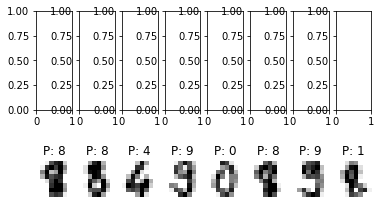

In [ ]:

from sklearn.datasets import load_digits
digits = load_digits()

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.5, random_state=0, shuffle=False)


optimizer=GradientDescent(eta=0.01, epochs=100, minibatches=1, random_seed=0,momentum=0.9)
lr = SoftmaxRegression()
lr.fit(x_train, y_train,optimizer,True)

predicted = lr.fit(x_train, y_train, optimizer,True).predict(x_test)
print(predicted)
print("ACCURACY")

count = 0
for index, y in enumerate(y_test):
    if predicted[index] - y != 0:
        count += 1   #Misclassification rate

print(100 - count/len(y_test)*100)
#print(1-sum(predicted-y_test)/y_test.shape)
_, axes = plt.subplots(2, 8)
print(predicted)
images_and_labels = list(zip(digits.images, digits.target))
#for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
#    ax.set_axis_off()
#    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
#    ax.set_title('Training: %i' % label)

# depending on training set size , adjust [n_samples//2:]
images_and_predictions = list(zip(digits.images[n_samples//2:], predicted))
for ax, (image, prediction) in zip(axes[1,:], images_and_predictions[:8]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('P: %i' % prediction)




In [ ]:
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
#get iris dataset from openml
iris = fetch_openml(name='iris')
print(iris.data.shape,iris.target.shape)
le = preprocessing.LabelEncoder()
n_samples = iris.target.shape[0]
print(iris.data.shape,iris.target.shape)
data = iris.data

# standardize
for i in range(4):
    data[:,i] = (data[:,i] - data[:,i].mean()) / data[:,i].std()

label_names=np.unique(iris.target)
le.fit(label_names)
label=le.transform(iris.target)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.5, random_state=0, shuffle=True)


optimizer=GradientDescent(eta=0.01, epochs=100, minibatches=1, random_seed=0,momentum=0.9)
lr = SoftmaxRegression()
lr.fit(x_train, y_train,optimizer,True)
predicted = lr.fit(x_train, y_train, optimizer,True).predict(x_test)
print(predicted)
print("ACCURACY")

count = 0
for index, y in enumerate(y_test):
    if predicted[index] - y != 0:
        count += 1   #Misclassification rate

print(100 - count/len(y_test)*100)

(150, 4) (150,)
(150, 4) (150,)
[2 1 0 2 0 2 0 2 2 2 2 2 2 2 2 0 2 1 0 0 2 2 0 0 2 0 0 2 1 0 2 2 0 2 2 1 0
 2 2 1 2 0 2 0 0 1 2 2 1 2 1 2 2 1 2 2 1 2 2 2 2 0 2 1 1 1 2 2 0 0 2 2 0 0
 2]
ACCURACY
72.0
/opt/venv/lib/python3.7/site-packages/sklearn/datasets/_openml.py:376: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


In [ ]:
print(label.shape)
print(y_test)

(150,)
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1]


# HYPERPARAMETER OPTIMIZATION

Implement and use 5-fold cross validation to estimate performance, in terms of accuracy, in
all of the experiments with respect to batch sizes, learning rates, and momentum parameters, and report the best
hyper-parameters you found.


You should track and analyze the validation and training accuracy (and optionally
the cost) to better understand and analyze the effect of different hyper-parameters. Each fold in cross-validation
will produce one of these training and validation curves. Plot one of these training and validation curves for
several representative choices of hyper-parameters in your report.

"""
Yes, this sentence is confusing. To clarify: after you found out the optimal hyperparameters set, you can alter one hyperparameter at a time and plot the averaged cross validation training and validation accuracy/error. Then analyze the changes of performance on the hyperparameter you altered. 
"""

In [34]:

# https://towardsdatascience.com/grid-search-in-python-from-scratch-hyperparameter-tuning-3cca8443727b

from random import seed
from random import randrange
import numpy as np

 
# Split a dataset into k folds
def cross_validation(hyperparams, dataset, targets, folds=5):
    dataset_split = []
    targets_split = []
    fold_size = int(len(dataset) / folds)
    start = 0
    for i in range(folds):
        dataset_split.append(dataset[start:start+fold_size])
        targets_split.append(targets[start:start+fold_size])
        start += fold_size

    x_train = []
    y_train = []
    x_test = []
    y_test = []
    accuracies = []
    t_acc = []
    v_acc = []

    for index in range(folds):
        x_test = np.array(dataset_split[index])
        y_test = np.array(targets_split[index])

        x_train = dataset_split[:index] + dataset_split[index+1:]
        x_train = np.array([item for items in x_train for item in items])
        y_train = targets_split[:index] + targets_split[index+1:]
        y_train = np.array([item for items in y_train for item in items])

        train_acc, val_acc = do_prediction(hyperparams, x_train, y_train, x_test, y_test)
        #print("Run: ", index+1, "Train Accuracy: ", train_acc)
        #print("Run: ", index+1, "Val Accuracy: ", val_acc)
        t_acc.append(train_acc)
        v_acc.append(val_acc)
    
    return np.mean(t_acc), np.mean(v_acc)


def do_prediction(hyperparams, x_train, y_train, x_test, y_test):
    optimizer=GradientDescent(eta=hyperparams['eta'], epochs=100, minibatches=hyperparams['minibatches'], 
    momentum=hyperparams['momentum'], random_seed=0)
    lr = SoftmaxRegression()

    model = lr.fit(x_train, y_train, optimizer,True)
    training = model.predict(x_train)
    validation = model.predict(x_test)
    train_acc = 0
    val_acc = 0

    for index, y in enumerate(y_train):
        if training[index] - y == 0:
            train_acc += 1   #Accuracy
    for index, y in enumerate(y_test):
        if validation[index] - y == 0:
            val_acc += 1   #Accuracy

    train_acc = train_acc/len(y_train)*100
    val_acc = val_acc/len(y_test)*100
    return train_acc, val_acc
 

# test cross validation split
#seed(1)

hyperparams = {
    'eta': 0.1,
    'minibatches':80,
    'momentum':0.9,
}

"""
from sklearn.datasets import load_digits
digits = load_digits()

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

cross_validation(hyperparams, data, digits.target, 5)
#print(folds[0].shape)
#print(data.shape)
"""

# Do validation for each, leaving one as validation set and others as training set
    
# minibatch 60 : (100.0, 92.20055710306409)
# minibatch 100 : (100.0, 91.42061281337047)



from sklearn.datasets import fetch_openml
from sklearn import preprocessing
#get iris dataset from openml
iris = fetch_openml(name='iris')

le = preprocessing.LabelEncoder()
n_samples = iris.target.shape[0]

data = iris.data

# standardize
for i in range(4):
    data[:,i] = (data[:,i] - data[:,i].mean()) / data[:,i].std()

label_names=np.unique(iris.target)
le.fit(label_names)
label=le.transform(iris.target)
#cross_validation(hyperparams, data, label, 5)


/opt/venv/lib/python3.7/site-packages/sklearn/datasets/_openml.py:376: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


(98.33333333333334, 93.33333333333334)

## Hyperparameters GRID SEARCH

In [38]:
### GRID SEARCH CV
"""
        self.eta = eta            #learning rate
        self.epochs = epochs
        self.l2 = l2
        self.minibatches = minibatches
        self.n_classes = n_classes
        self.random_seed = random_seed
        self.momentum=momentum
"""

from sklearn.datasets import load_digits
digits = load_digits()

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))


hyperparams = {
    'eta': [0.01, 0.05, 0.1, 0.5],
    'minibatches':[1, 10, 20, 50],
    'momentum':[0.9, 0.95, 0.99, 0.999],
}

#hyperparams = {
#    'eta': [0.01, 0.05, 0.1],
#    'minibatches':[1, 20, 50],
#    'momentum':[0.9, 0.95, 0.99],
#}


def GridSearch(X, Y):
    graph_t = []
    graph_v = []
    graph_w = []
    graph_x = []
    graph_y = []

    for eta in hyperparams['eta']:
        graph_t_row = []
        graph_v_row = []
        graph_w_row = []
        graph_x_row = []
        graph_y_row = []

        for minibatches in hyperparams['minibatches']:

            for momentum in hyperparams['momentum']:
                params = {}
                params['eta'] = eta
                params['minibatches'] = minibatches
                params['momentum'] = momentum
                t_acc, v_acc = cross_validation(params, X, Y, 5)
                graph_t_row.append(t_acc)
                graph_v_row.append(v_acc)
                graph_w_row.append(eta)
                graph_x_row.append(minibatches)
                graph_y_row.append(momentum)

        graph_t.append(graph_t_row)
        graph_v.append(graph_v_row)
        graph_w.append(graph_w_row)
        graph_x.append(graph_x_row)
        graph_y.append(graph_y_row)
        print('')

    graph_t=np.array(graph_t)
    graph_v=np.array(graph_v)
    graph_w=np.array(graph_w)
    graph_x=np.array(graph_x)
    graph_y=np.array(graph_y)

    max_v = np.max(graph_v)
    pos_max_v = np.argwhere(graph_v == np.max(graph_v))[0]

    print('Max Accuracy: %.4f' %(max_v))
    print('Optimum eta: %f' %(graph_w[pos_max_v[0],pos_max_v[1]]))
    print('Optimum batch size: %f' %(graph_x[pos_max_v[0],pos_max_v[1]]))
    print('Optimum momentum: %f' %(graph_y[pos_max_v[0],pos_max_v[1]]))

    return graph_t, graph_v, graph_w, graph_x,graph_y
    

t, v, w, x, y = GridSearch(data, digits.target)




/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in multiply

Max Accuracy: 92.9248
Optimum eta: 0.010000
Optimum batch size: 10.000000
Optimum momentum: 0.900000


# Plotting Training and Validation curves as Hyperparameters Vary

Plot one of these training and validation curves for several representative choices of hyperparameters

""" Yes, this sentence is confusing. To clarify: after you found out the optimal hyperparameters set, you can alter one hyperparameter at a time and plot the averaged cross validation training and validation accuracy/error. Then analyze the changes of performance on the hyperparameter you altered. """

In [ ]:
# Plotting Training and Validation curves

# p = value of hyperparameter that's being varied
# p_name = name of that hyperparameter (eta, minibatches, momentum)

def plot_train_val(hyperparams, p_name, p, X, Y):
    p_values = list(range(0.1, 5, 0.1))
    p_values = [p*value for value in p_values]
    for param in p_values:
        hyperparams[p_name] = param
        t_acc, v_acc = cross_validation(params, X, Y, 5)
    



### Comparsion against another classifier
#### data sets
    iris
    load_digits
    
#### Logistic regression
#### lasso & ridge regression
 hyperparameter: Learning rate (eta), batch size (minibatches), momentum (momentum)
 

#### function for cross-validation on all possible combination of hyperparameteres

In [ ]:
def (X, Y):
    hyperparams = {
        'eta': [0.01, 0.05, 0.1, 0.5],
        'minibatches':[1, 10, 20, 50],
        'momentum':[0.9, 0.95, 0.99, 0.999],
    }

    f

### Iris

#### Ridge Regression

In [ ]:

from sklearn.linear_model import LinearRegression as LR,Ridge,Lasso
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
#get iris dataset from openml
iris = fetch_openml(name='iris')
print(iris.data.shape,iris.target.shape)
le = preprocessing.LabelEncoder()
n_samples = iris.target.shape[0]
print(iris.data.shape,iris.target.shape)
data = iris.data

# standardize
for i in range(4):
    data[:,i] = (data[:,i] - data[:,i].mean()) / data[:,i].std()

label_names=np.unique(iris.target)
le.fit(label_names)
label=le.transform(iris.target)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.5, random_state=0, shuffle=True)


# ridge regression
reg = Ridge(alpha=100).fit(x_train,y_train) 


yhat = reg.predict(x_test)
from sklearn.metrics import r2_score
accuracy=r2_score(y_test,yhat) 
print(accuracy)




(150, 4) (150,)
(150, 4) (150,)
ACCURACY
0.7731602803655285
/opt/venv/lib/python3.7/site-packages/sklearn/datasets/_openml.py:376: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


#### Ridge regression with cross-validation

#### Lasso Regression

In [ ]:
lasso_ = Lasso(alpha=0.1).fit(x_train,y_train) 

yhat = lasso_.predict(x_test)
from sklearn.metrics import r2_score
accuracy=r2_score(y_test,yhat) 
print(accuracy)

0.8684340508117177


#### Lasso Regression with cross-validation

#### Logistic Regression

In [ ]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(x_train, y_train)

yhat = logreg.predict(x_test)
from sklearn.metrics import r2_score
accuracy=r2_score(y_test,yhat) 
print(accuracy)

0.9554367201426025


### digits

#### Ridge regression

In [31]:
from sklearn.linear_model import LinearRegression as LR,Ridge,Lasso
from sklearn.datasets import load_digits
digits = load_digits()

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.5, random_state=0, shuffle=False)


# ridge regression
reg = Ridge(alpha=100).fit(x_train,y_train) 


yhat = reg.predict(x_test)
from sklearn.metrics import r2_score
accuracy=r2_score(y_test,yhat) 
print(accuracy)

0.4930141686760242


#### Ridge regression with cross-validation

#### Lasso regression

In [36]:
lasso_ = Lasso(alpha=0.1).fit(x_train,y_train) 

yhat = lasso_.predict(x_test)
from sklearn.metrics import r2_score
accuracy=r2_score(y_test,yhat) 
print(accuracy)

0.5157866202624848


#### Lasso regression with cross-validation

#### logistic regression

In [37]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(x_train, y_train)

yhat = logreg.predict(x_test)
from sklearn.metrics import r2_score
accuracy=r2_score(y_test,yhat) 
print(accuracy)

0.8234621061917531
